In [51]:
import pandas as pd
import numpy as np

# Load Train Data and Labels

In [52]:
%%time

train = pd.read_csv(r".\predict-student-performance-from-game-play\train.csv")
print(train.shape)
print(train.head())


(13174211, 20)
          session_id  index  elapsed_time      event_name   name  level  page  \
0  20090312431273200      0             0  cutscene_click  basic      0   NaN   
1  20090312431273200      1          1323    person_click  basic      0   NaN   
2  20090312431273200      2           831    person_click  basic      0   NaN   
3  20090312431273200      3          1147    person_click  basic      0   NaN   
4  20090312431273200      4          1863    person_click  basic      0   NaN   

   room_coor_x  room_coor_y  screen_coor_x  screen_coor_y  hover_duration  \
0  -413.991405  -159.314686          380.0          494.0             NaN   
1  -413.991405  -159.314686          380.0          494.0             NaN   
2  -413.991405  -159.314686          380.0          494.0             NaN   
3  -413.991405  -159.314686          380.0          494.0             NaN   
4  -412.991405  -159.314686          381.0          494.0             NaN   

                            text   

In [53]:
targets = pd.read_csv(r".\predict-student-performance-from-game-play\train_labels.csv")
targets["session"] = targets["session_id"].apply(lambda x: int(x.split("_")[0]))
targets["question"] = targets["session_id"].apply(lambda x: int(x.split("_")[-1][1:]))
print(targets.shape)
print(targets.head())


(212022, 4)
             session_id  correct            session  question
0  20090312431273200_q1        1  20090312431273200         1
1  20090312433251036_q1        0  20090312433251036         1
2  20090314121766812_q1        1  20090314121766812         1
3  20090314363702160_q1        1  20090314363702160         1
4  20090314441803444_q1        1  20090314441803444         1


# Feature Engineering

In [54]:
# print unique values
# print(train.columns)
# for col in train:
#     print(col)
#     print(train[col].unique())


In [55]:
CAT_COLS = ["event_name", "fqid", "room_fqid", "text"]
NUM_COLS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
            'screen_coor_x', 'screen_coor_y', 'hover_duration']

EVENTS = [x for x in train["event_name"].unique()]

In [56]:
def feature_engineer(data: pd.DataFrame):
    dfs = []
    for col in CAT_COLS:
        temp = data.groupby(["session_id", "level_group"])[col].agg("nunique")
        temp.name = f"{temp.name}_nunique"
        dfs.append(temp)
    
    for col in NUM_COLS:
        temp = data.groupby(["session_id", "level_group"])[col].agg("mean")
        temp.name = f"{temp.name}_mean"
        dfs.append(temp)
    
    for col in NUM_COLS:
        temp = data.groupby(["session_id", "level_group"])[col].agg("std")
        temp.name = f"{temp.name}_std"
        dfs.append(temp)
    
    for ev in EVENTS:
        data[ev] = (data["event_name"] == ev).astype("int8")    # turn bool series into 0-1 values series
    
    for ev in EVENTS + ["elapsed_time"]:
        temp = data.groupby(["session_id", "level_group"])[ev].agg("sum")
        temp.name = f"{temp.name}_sum"
        dfs.append(temp)
    
    data = data.drop(EVENTS, axis=1)
    df = pd.concat(dfs, axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index("session_id")

    return df

In [57]:
%%time
refined_train = feature_engineer(train)
print(refined_train.shape)
refined_train.head()


(35337, 33)
Wall time: 1min 15s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,observation_click_sum,notification_click_sum,object_click_sum,object_hover_sum,map_hover_sum,map_click_sum,checkpoint_sum,notebook_click_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.701275,-71.413749,...,81.0,4,8,11.0,4.0,4.0,2.0,1,0.0,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.347170,-162.004310,...,170.0,3,10,20.0,13.0,14.0,6.0,1,0.0,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306062,-57.269322,...,103.0,1,9,28.0,21.0,9.0,8.0,1,0.0,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.045960,-53.671082,...,49.0,2,5,15.0,5.0,3.0,3.0,1,2.0,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.762282,-142.861892,...,637.0,5,14,83.0,66.0,186.0,45.0,1,50.0,3241011333


# Train XGBoost Model

In [58]:
FEATURES = [col for col in refined_train.columns if col != "level_group"]
print(f"Number of features is: {len(FEATURES)}")
ALL_USERS = refined_train.index.unique()
print(f"Number of users is: {len(ALL_USERS)}")

Number of features is: 32
Number of users is: 11779


In [59]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm

In [60]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS), 18)), index=ALL_USERS)
models = {}

# 5 Group K fold
for i, (train_index, test_index) in tqdm(enumerate(gkf.split(X=refined_train, groups=refined_train.index))):
    print("#=" * 20)
    print("#=" * 9, f" {i+1} ", "#=" * 9)
    print("#=" * 20)

    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}

    # Iterate through question 1 to 18
    for q in range(1, 19):

        # Use the respective dataset
        if q <= 3: grp = '0-4'
        elif q <= 13: grp = '5-12'
        elif q <= 22: grp = '13-22'

        # Train data
        train_x = refined_train.iloc[train_index]
        train_x = train_x.loc[train_x["level_group"] == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets["question"] == q].set_index("session").loc[train_users]

        # Valid data
        valid_x = refined_train.iloc[test_index]
        valid_x = valid_x.loc[valid_x["level_group"] == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets["question"] == q].set_index("session").loc[valid_users]

        # Train model
        clf = XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype("float32"), train_y["correct"], eval_set=[(valid_x[FEATURES].astype("float32"), valid_y["correct"])], verbose = 0)

        print(f"{q}({clf.best_ntree_limit}), ",end = "")

        # Save model
        models[f"{grp}_{q}"] = clf
        oof.loc[valid_users, q-1] = clf.predict_proba(valid_x[FEATURES].astype("float32"))[:, 1]

0it [00:00, ?it/s]

#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=  1  #=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
1(134), 2(123), 3(94), 4(279), 5(85), 6(204), 7(127), 8(79), 9(97), 10(206), 11(213), 12(68), 13(165), 14(134), 15(141), 16(70), 17(65), 

1it [00:09,  9.28s/it]

18(132), #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=  2  #=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
1(136), 2(105), 3(125), 4(109), 5(86), 6(174), 7(117), 8(66), 9(112), 10(160), 11(68), 12(84), 13(74), 14(152), 15(186), 16(85), 17(40), 

2it [00:18,  9.19s/it]

18(102), #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=  3  #=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
1(54), 2(131), 3(97), 4(168), 5(66), 6(74), 7(80), 8(56), 9(150), 10(110), 11(72), 12(74), 13(153), 14(166), 15(133), 16(88), 17(84), 

3it [00:26,  8.58s/it]

18(117), #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=  4  #=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
1(161), 2(122), 3(111), 4(134), 5(154), 6(122), 7(168), 8(46), 9(63), 10(92), 11(85), 12(99), 13(90), 14(123), 15(162), 16(45), 17(82), 

4it [00:35,  8.86s/it]

18(151), #=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=  5  #=#=#=#=#=#=#=#=#=
#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=#=
1(147), 2(151), 3(94), 4(78), 5(156), 6(144), 7(134), 8(50), 9(147), 10(138), 11(60), 12(79), 13(123), 14(128), 15(232), 16(98), 17(98), 

5it [00:44,  8.95s/it]

18(71), 

# Compute CV Score

In [61]:
true_labels = oof.copy()
for q in range(18):
    temp = targets.loc[targets["question"] == q + 1].set_index("session").loc[ALL_USERS]
    true_labels[q] = temp["correct"].values

In [62]:
# Find the best threshhold to convert probabilities into 0s and 1s
scores = []
thresholds = []
best_score = 0
optimum_thresh = 0

for threshold in np.arange(0.4, 0.81, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype("int")
    m = f1_score(true_labels.values.reshape(-1), preds, average="macro")
    scores.append(m)
    thresholds.append(threshold)

    if m > best_score:
        best_score = m
        optimum_thresh = threshold

    print(f"{threshold:.02f} F1 is: {m:.02f}")

0.40 F1 is: 0.59
0.41 F1 is: 0.60
0.42 F1 is: 0.60
0.43 F1 is: 0.61
0.44 F1 is: 0.62
0.45 F1 is: 0.62
0.46 F1 is: 0.63
0.47 F1 is: 0.63
0.48 F1 is: 0.64
0.49 F1 is: 0.64
0.50 F1 is: 0.64
0.51 F1 is: 0.65
0.52 F1 is: 0.65
0.53 F1 is: 0.66
0.54 F1 is: 0.66
0.55 F1 is: 0.66
0.56 F1 is: 0.67
0.57 F1 is: 0.67
0.58 F1 is: 0.67
0.59 F1 is: 0.67
0.60 F1 is: 0.68
0.61 F1 is: 0.68
0.62 F1 is: 0.68
0.63 F1 is: 0.68
0.64 F1 is: 0.68
0.65 F1 is: 0.68
0.66 F1 is: 0.67
0.67 F1 is: 0.67
0.68 F1 is: 0.67
0.69 F1 is: 0.66
0.70 F1 is: 0.66
0.71 F1 is: 0.65
0.72 F1 is: 0.65
0.73 F1 is: 0.64
0.74 F1 is: 0.63
0.75 F1 is: 0.62
0.76 F1 is: 0.61
0.77 F1 is: 0.61
0.78 F1 is: 0.60
0.79 F1 is: 0.59
0.80 F1 is: 0.58


Text(0.6300000000000002, 0.6685462455724889, '(0.630, 0.679)')

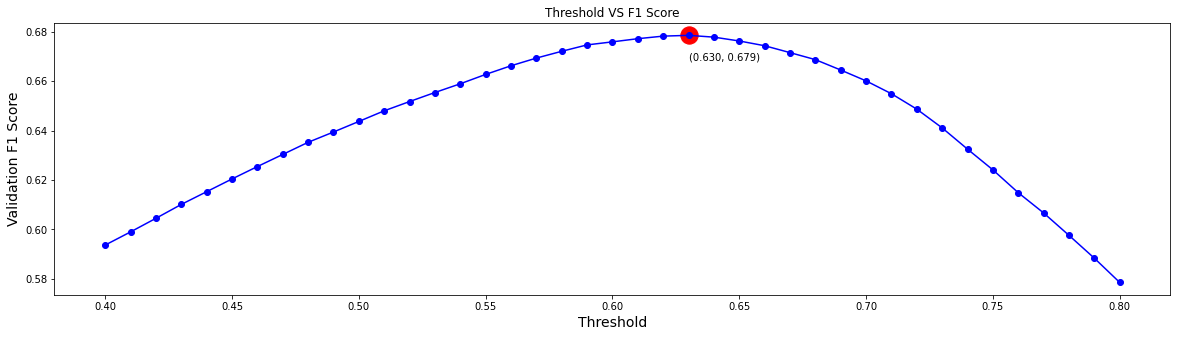

In [63]:
# Plot f1 score and threshold respectively
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, "-o", color="blue")
plt.scatter([optimum_thresh], [best_score], color="red", s=300, alpha=1)
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score", size=14)
plt.title(f"Threshold VS F1 Score")
plt.text(x=optimum_thresh, y=(best_score - 0.01), s=f"({optimum_thresh:.3f}, {best_score:.3f})")

In [64]:
# Compute F1 score for each and every question separately
for q in range(18):
    m = f1_score(true_labels.iloc[:, q].values, (oof.iloc[:, q].values > optimum_thresh).astype("int"), average="macro")
    print(f"F1_Q{q + 1} is: {m}")

ov_m = m = f1_score(true_labels.values.reshape(-1), (oof.values.reshape(-1) > optimum_thresh).astype("int"), average='macro')
print(f"Overal F1 score is: {ov_m}")

F1_Q1 is: 0.592855843528205
F1_Q2 is: 0.4946153516111039
F1_Q3 is: 0.48973998380435246
F1_Q4 is: 0.612440868907625
F1_Q5 is: 0.572710485478007
F1_Q6 is: 0.6093047271703211
F1_Q7 is: 0.5935265231876988
F1_Q8 is: 0.5255075501274166
F1_Q9 is: 0.6043634834136493
F1_Q10 is: 0.5099760312395695
F1_Q11 is: 0.5946438945442235
F1_Q12 is: 0.49610501048311995
F1_Q13 is: 0.43627328411924765
F1_Q14 is: 0.6053149803699469
F1_Q15 is: 0.5133400547607433
F1_Q16 is: 0.4566360258669387
F1_Q17 is: 0.5457541644806447
F1_Q18 is: 0.49052080932415365
Overal F1 score is: 0.6785462455724889
